In [1]:
from scipy.optimize import fsolve
import os
from models.forward import LoadForwardModel
from models.configs import models_configs, LoadData
from models.inverse_diffusion_from_sdf import LoadDiffusionInverseModel
from utils.sdf2geo import filter_out_unit_cell
from utils.run_abaqus import run_abaqus_sim
import torch
import numpy as np
import matplotlib.pyplot as plt
import time

device = "cuda" if torch.cuda.is_available() else "cpu"
# TODO: change to your abaqus path, set None if you don't have abaqus
ABAQUS_EXE = "/projects/bbkg/Abaqus/2024/Commands/abaqus"

In [2]:
configs = models_configs()
fwd_filebase = configs["ForwardModel"]["filebase"]
fwd_args = configs["ForwardModel"]["model_args"]
geoencoder_args = configs["GeoEncoder"]["model_args"]
inv_filebase = configs["InvDiffusion"]["filebase"]
inv_args = configs["InvDiffusion"]["model_args"]

inv_Unet, gaussian_diffusion = LoadDiffusionInverseModel(
    inv_filebase, inv_args)
fwd = LoadForwardModel(fwd_filebase, fwd_args, geoencoder_args)


Total number of trainable parameters of inverse Unet of diffusion: 4189569
Total number of parameters of Geo encoder: 1132160, 1132160 of which are trainable
Total number of parameters of SDF NN: 4203517, 4203517 of which are trainable
Total number of trainable parameters of fwd model: 2251358


In [3]:
train_dataset, test_dataset, grid_coor, sdf_inv_scaler, stress_inv_scaler = LoadData(
    seed=420)



In [4]:

def inv_diffusion(Ytarget, num_sol=100, seed=None, w=2):
    # Ytarget = test_dataset[testID][1].unsqueeze(0)
    Ytarget = Ytarget.to(device)
    labels = Ytarget.repeat(num_sol, 1)
    sdf = gaussian_diffusion.sample(
        inv_Unet, labels, w=w, clip_denoised=False, seed=seed
    )
    sdf = torch.tensor(sdf).to(device)
    with torch.no_grad():
        Ypred = fwd.forward_from_sdf(sdf)
    Ypred_inv = stress_inv_scaler(Ypred.cpu().detach().numpy())
    Ytarg_inv = stress_inv_scaler(labels.cpu().detach().numpy())
    Xpred_inv = sdf_inv_scaler(sdf.cpu().detach().numpy())
    Xpred_inv = Xpred_inv.squeeze()
    return Xpred_inv, Ypred_inv, Ytarg_inv


In [5]:


def design_test(Ytarget, filebase, num_sol=100, seed=None, w=2, threshold=0.05, abaqus_exe=ABAQUS_EXE, overwrite=False):
    start = time.time()
    Xpred_inv, Ypred_inv, Ytarg_inv = inv_diffusion(
        Ytarget, num_sol=num_sol, seed=seed, w=w)
    end = time.time()
    print(f"Time taken for one solution: {(end-start)/num_sol} s")
    """evaluate the  accuracy design results by forward model"""

    L2error = np.linalg.norm(Ypred_inv - Ytarg_inv, axis=1) / \
        np.linalg.norm(Ytarg_inv, axis=1)
    fig = plt.figure(figsize=(4.8, 3.6))
    ax = plt.subplot(1, 1, 1)
    _ = ax.hist(L2error, bins=20, color="skyblue", edgecolor="black")
    ax.set_xlabel("L2 relative error")
    ax.set_ylabel("Frequency")
    mean, std = np.mean(L2error), np.std(L2error)
    print(f"Mean L2 error of the diffusion design results: {mean}, std: {std}")
    """random select the 4 designs"""
    # filter out the periodic unit cells
    geo_contours, periodic_ids = filter_out_unit_cell(
        Xpred_inv)
    Ypred_inv = Ypred_inv[periodic_ids]
    Ytarg_inv = Ytarg_inv[periodic_ids]
    L2error = L2error[periodic_ids]
    if threshold is not None:
        np.random.seed(seed)
        evl_ids = np.random.choice(
            np.where(L2error < threshold)[0], 4, replace=False)
    else:
        evl_ids = np.argsort(L2error)[:4]
    for i, idx in enumerate(evl_ids):
        print(f"ID: {idx}, L2 error: {L2error[idx]}")
    strain = np.linspace(0, 0.2, 51)
    cases = ["c", "d", "e", "f"]
    """run abaqus simulation for selected designs"""
    fem_stress = []
    for i, idx in enumerate(evl_ids):
        print(f"Running Abaqus simulation for case {cases[i]}")
        working_dir = os.path.join(filebase, cases[i])
        femdata = run_abaqus_sim(
            geo_contours[evl_ids[i]], working_dir, abaqus_exe, overwrite=overwrite)
        fem_stress.append(femdata[:, 1])
    fem_stress = np.array(fem_stress)
    """plot the results"""
    legends = [
        f"{cases[i]} ({L2error[evl_ids[i]]*100:.1f}%)" for i in range(4)]
    nr, nc = 2, 3
    fig, axes = plt.subplots(nr, nc, figsize=(
        nc*4.8, nr*3.6), constrained_layout=True)
    ax = axes[0, 0]
    ax.plot(strain*100, Ytarg_inv[0], '-bo', label="Target", markersize=4)
    for i, v in enumerate(evl_ids):
        ax.plot(strain*100, Ypred_inv[v], '--', label=legends[i])
    ax.legend()
    ax.set_xlabel(r"$\varepsilon~[\%]$")
    ax.set_ylabel(r"$\sigma~[MPa]$")
    for i, v in enumerate(evl_ids):
        shell_contours, holes_contours = geo_contours[v]
        ax = axes[0, i+1] if i < 2 else axes[1, i-1]
        for contour in shell_contours:
            x, y = contour[:, 1], contour[:, 0]
            ax.fill(x, y, alpha=1.0, edgecolor="black",
                    facecolor="cyan", label="Outer Boundary")
        for contour in holes_contours:
            x, y = contour[:, 1], contour[:, 0]
            ax.fill(x, y, alpha=1.0, edgecolor="black",
                    facecolor="white", label="Hole")
        ax.axis("equal")  # Keep aspect ratio square
        ax.set_xlabel("x [mm]")
        ax.set_ylabel("y [mm]")
        ax.set_xlim([-0.01, 1.01])
        ax.set_ylim([-0.1, 1.1])
    L2error_fem = np.linalg.norm(fem_stress - Ytarg_inv[:1], axis=1) / \
        np.linalg.norm(Ytarg_inv[:1], axis=1)
    legends = [f"{cases[i]} ({L2error_fem[i]*100:.1f}%)" for i in range(4)]
    ax = axes[1, 0]
    ax.plot(strain*100, Ytarg_inv[0], '-bo', label="Target", markersize=4)
    for i in range(4):
        if fem_stress[i][0] is np.nan:
            continue
        ax.plot(strain*100, fem_stress[i], '--', label=legends[i])
    ax.legend()
    ax.set_xlabel(r"$\varepsilon~[\%]$")
    ax.set_ylabel(r"$\sigma~[MPa]$")
    return geo_contours, Ypred_inv, Ytarg_inv



Test ID: 2897


sampling loop time step: 100%|██████████| 500/500 [01:32<00:00,  5.39it/s]


Time taken for one solution: 0.464801561832428 s
Mean L2 error of the diffusion design results: 0.05477842316031456, std: 0.037679120898246765
ID: 51, L2 error: 0.027410447597503662
ID: 9, L2 error: 0.03126553073525429
ID: 37, L2 error: 0.011966594494879246
ID: 58, L2 error: 0.009806263260543346
Running Abaqus simulation for case c


Abaqus License Manager checked out the following license:
"cae" from Flexnet server 141.142.193.80
<2 out of 3 licenses remain available>.


Running Abaqus simulation for case d


Abaqus License Manager checked out the following license:
"cae" from Flexnet server 141.142.193.80
<2 out of 3 licenses remain available>.


Running Abaqus simulation for case e


Abaqus License Manager checked out the following license:
"cae" from Flexnet server 141.142.193.80
<2 out of 3 licenses remain available>.


Running Abaqus simulation for case f


Abaqus License Manager checked out the following license:
"cae" from Flexnet server 141.142.193.80
<2 out of 3 licenses remain available>.


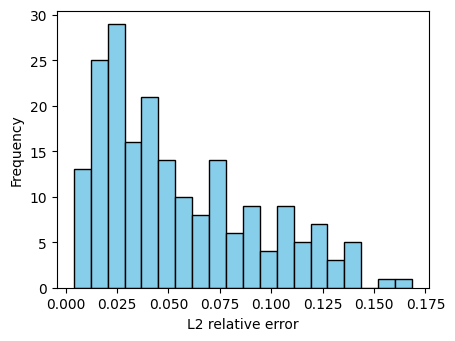

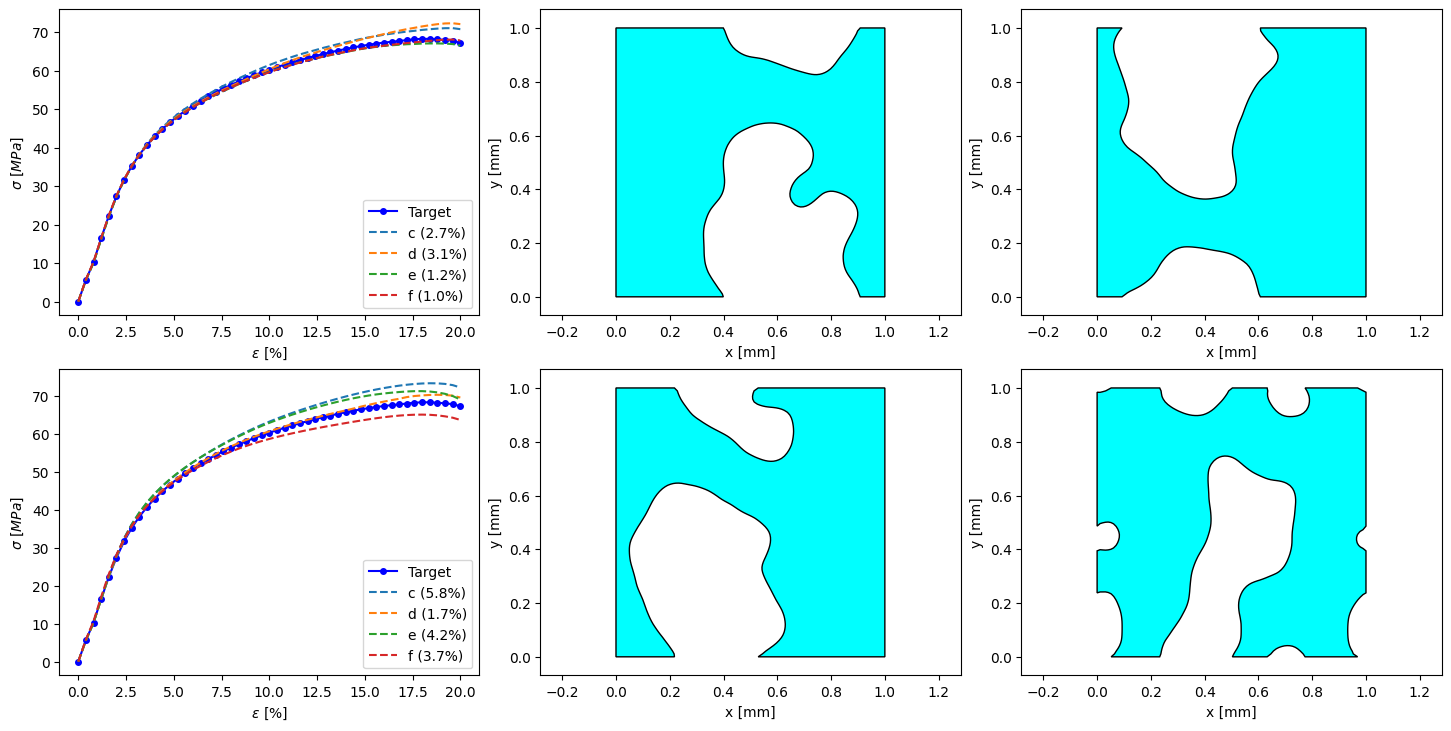

In [6]:
seed = 37388
np.random.seed(seed)
testID = np.random.randint(0, len(test_dataset))
print(f"Test ID: {testID}")
seed_ = np.random.randint(0, 100000)
Ytarget = test_dataset[testID][1].unsqueeze(0)
filebase = f"./abaqus_sims/testID{testID}"
geo_contours, Ypred, Ytarg = design_test(
    Ytarget, filebase, num_sol=200, threshold=0.05, w=2, seed=seed_, overwrite=True)


Test ID: 9376


sampling loop time step: 100%|██████████| 500/500 [01:32<00:00,  5.40it/s]


Time taken for one solution: 0.46371912598609927 s
Mean L2 error of the diffusion design results: 0.13214655220508575, std: 0.07207231223583221
ID: 22, L2 error: 0.04704742133617401
ID: 50, L2 error: 0.023760052397847176
ID: 33, L2 error: 0.03923022001981735
ID: 122, L2 error: 0.04454191401600838
Running Abaqus simulation for case c


Abaqus License Manager checked out the following license:
"cae" from Flexnet server 141.142.193.80
<2 out of 3 licenses remain available>.


Running Abaqus simulation for case d


Abaqus License Manager checked out the following license:
"cae" from Flexnet server 141.142.193.80
<2 out of 3 licenses remain available>.


Running Abaqus simulation for case e


Abaqus License Manager checked out the following license:
"cae" from Flexnet server 141.142.193.80
<2 out of 3 licenses remain available>.


Running Abaqus simulation for case f


Abaqus License Manager checked out the following license:
"cae" from Flexnet server 141.142.193.80
<2 out of 3 licenses remain available>.


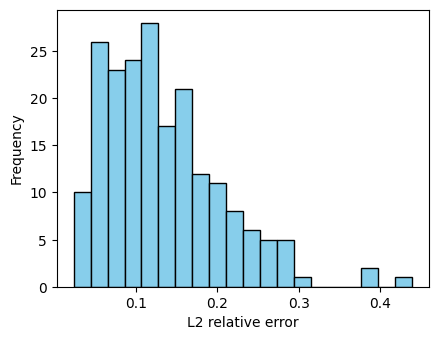

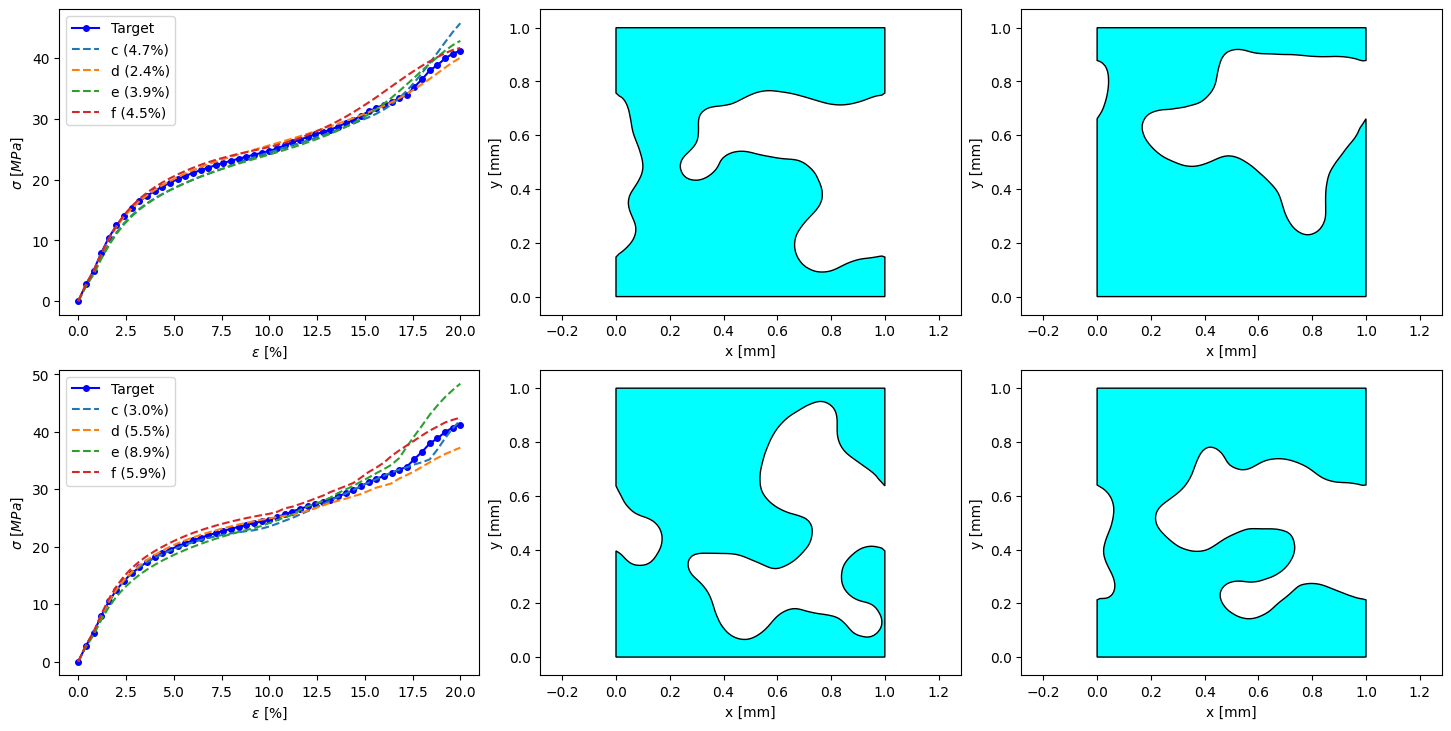

In [7]:
seed = 55161
np.random.seed(seed)
testID = np.random.randint(0, len(test_dataset))
print(f"Test ID: {testID}")
seed_ = np.random.randint(0, 100000)
Ytarget = test_dataset[testID][1].unsqueeze(0)
filebase = f"./abaqus_sims/testID{testID}"
geo_contours, Ypred, Ytarg = design_test(
    Ytarget, filebase, num_sol=200, threshold=0.05, w=2, seed=seed_, overwrite=True)


Test ID: 6653


sampling loop time step: 100%|██████████| 500/500 [01:32<00:00,  5.40it/s]


Time taken for one solution: 0.46328189730644226 s
Mean L2 error of the diffusion design results: 0.14720217883586884, std: 0.07283937931060791
ID: 59, L2 error: 0.04971487820148468
ID: 78, L2 error: 0.04455535113811493
ID: 39, L2 error: 0.04474906995892525
ID: 36, L2 error: 0.040261413902044296
Running Abaqus simulation for case c


Abaqus License Manager checked out the following license:
"cae" from Flexnet server 141.142.193.80
<2 out of 3 licenses remain available>.


Running Abaqus simulation for case d


Abaqus License Manager checked out the following license:
"cae" from Flexnet server 141.142.193.80
<2 out of 3 licenses remain available>.


Running Abaqus simulation for case e


Abaqus License Manager checked out the following license:
"cae" from Flexnet server 141.142.193.80
<2 out of 3 licenses remain available>.


Running Abaqus simulation for case f


Abaqus License Manager checked out the following license:
"cae" from Flexnet server 141.142.193.80
<2 out of 3 licenses remain available>.


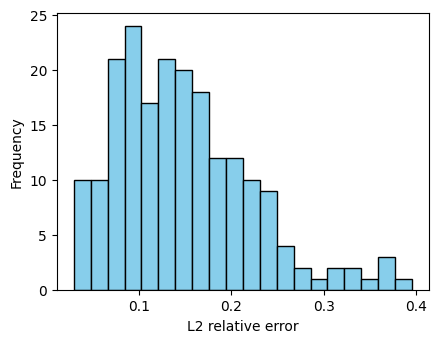

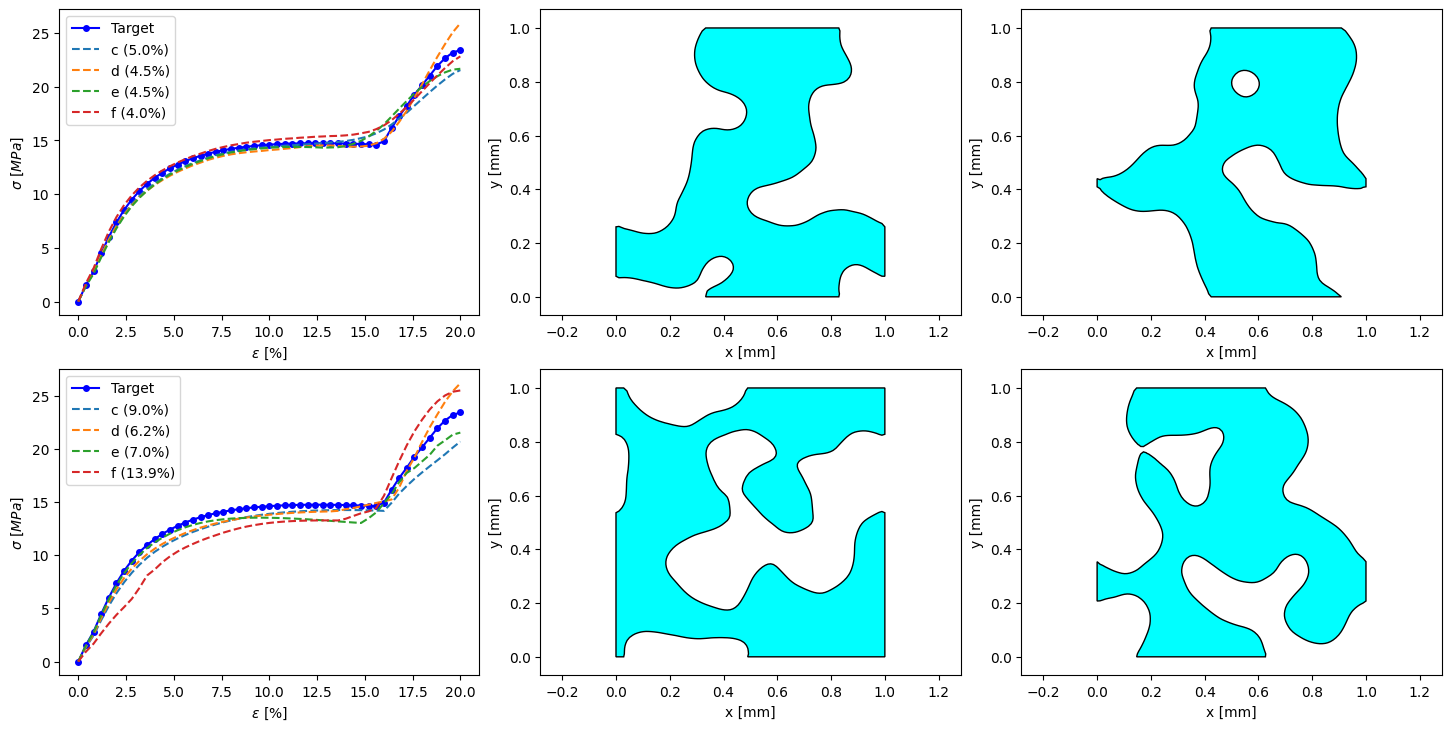

In [8]:
seed = 71114
np.random.seed(seed)
testID = np.random.randint(0, len(test_dataset))
print(f"Test ID: {testID}")
seed_ = np.random.randint(0, 100000)
Ytarget = test_dataset[testID][1].unsqueeze(0)
filebase = f"./abaqus_sims/testID{testID}"
geo_contours, Ypred, Ytarg = design_test(
    Ytarget, filebase, num_sol=200, threshold=0.05, w=2, seed=seed_, overwrite=True)


In [6]:
# Ondemand desgin: target from Ramberg-Osgood model

def ramberg_osgood_eq(sigma, epsilon, E, sigma_0, alpha, n):
    return epsilon - (sigma / E + alpha * (sigma / sigma_0) ** n)


def ondemand_target(E, sigma_0, alpha, n, idx_e=None):
    epsilon_v = np.linspace(0, 0.2, 51)
    if idx_e is None:
        sigma = np.array([fsolve(ramberg_osgood_eq, x0=epsilon * E, args=(epsilon, E, sigma_0, alpha, n))[0]
                          for epsilon in epsilon_v])
    else:
        epsilon_1st = epsilon_v[:idx_e]
        sigma_1st = np.array([fsolve(ramberg_osgood_eq, x0=epsilon * E, args=(epsilon, E, sigma_0, alpha, n))[0]
                              for epsilon in epsilon_1st])
        epsilon_2nd = epsilon_v[idx_e-1:]
        sigma_2nd = (sigma_1st[-1] + E*0.6 * (epsilon_2nd-epsilon_1st[-1]))
        sigma = np.concatenate((sigma_1st, sigma_2nd[1:]))
        fig = plt.figure(figsize=(4.8, 3.6))
    plt.figure(figsize=(6, 4))
    plt.plot(epsilon_v, sigma, color='b')
    plt.xlabel(r"$\varepsilon~[\%]$")
    plt.ylabel(r"$\sigma~[MPa]$")
    plt.title("Target Stress-Strain Curve (Ramberg-Osgood)")
    return sigma.astype(np.float32)


s_shift = stress_inv_scaler(0)
s_scale = stress_inv_scaler(1)-s_shift

sampling loop time step: 100%|██████████| 500/500 [03:59<00:00,  2.09it/s]


Time taken for one solution: 0.4791583209037781 s
Mean L2 error of the diffusion design results: 0.235319584608078, std: 0.09401803463697433
ID: 13, L2 error: 0.028950925916433334
ID: 57, L2 error: 0.06402210146188736
ID: 121, L2 error: 0.08190355449914932
ID: 17, L2 error: 0.08205569535493851
Running Abaqus simulation for case c


Abaqus License Manager checked out the following license:
"cae" from Flexnet server 141.142.193.80
<2 out of 3 licenses remain available>.


Running Abaqus simulation for case d


Abaqus License Manager checked out the following license:
"cae" from Flexnet server 141.142.193.80
<2 out of 3 licenses remain available>.


Running Abaqus simulation for case e


Abaqus License Manager checked out the following license:
"cae" from Flexnet server 141.142.193.80
<2 out of 3 licenses remain available>.


Running Abaqus simulation for case f


Abaqus License Manager checked out the following license:
"cae" from Flexnet server 141.142.193.80
<2 out of 3 licenses remain available>.


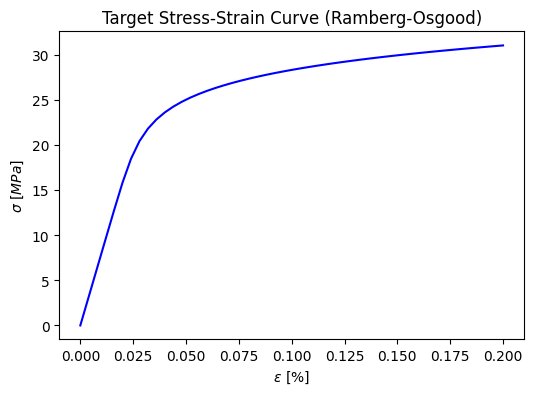

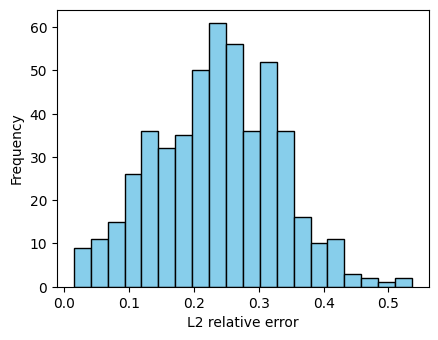

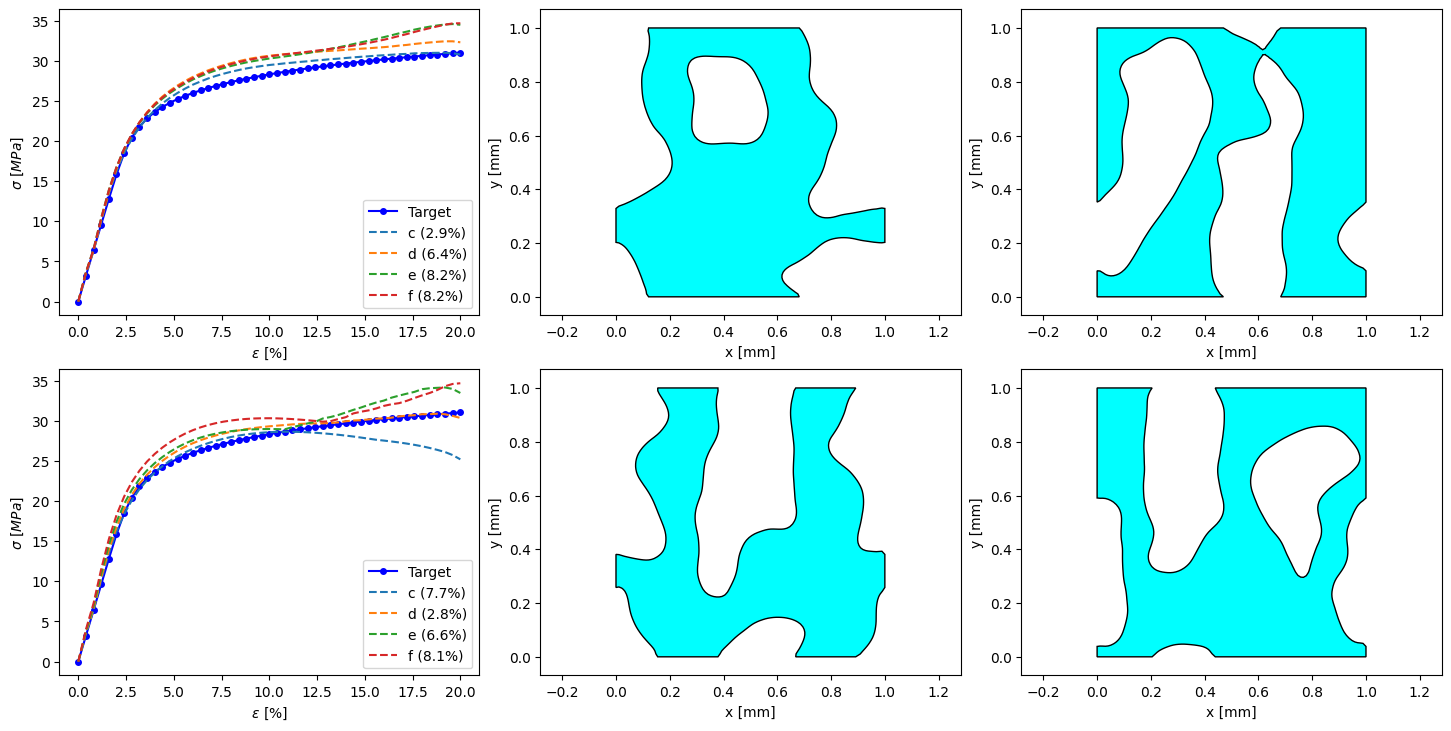

In [ ]:
# Ondemand design case 1
# Material properties
E = 800     # Young's modulus (MPa)
sigma_0 = 20  # Reference yield stress (MPa)
alpha = 0.002   # Coefficient
n = 10           # Hardening exponent
y_demand1 = ondemand_target(E, sigma_0, alpha, n)
y_demand_target1 = (y_demand1-s_shift)/s_scale
y_demand_target1 = torch.tensor(y_demand_target1)[None, :].to(device)
filebase = f"./abaqus_sims/ondemand_case1"
seed = 42
np.random.seed(seed)
seed_ = np.random.randint(0, 100000)
geo_contours, Ypred, Ytarg = design_test(
    y_demand_target1, filebase, num_sol=500, threshold=None, w=2, seed=seed_, overwrite=True)


sampling loop time step: 100%|██████████| 500/500 [03:58<00:00,  2.10it/s]


Time taken for one solution: 0.4766537599563599 s
Mean L2 error of the diffusion design results: 0.19334833323955536, std: 0.06113867089152336
ID: 4, L2 error: 0.0551159642636776
ID: 87, L2 error: 0.05711514875292778
ID: 282, L2 error: 0.05798167735338211
ID: 133, L2 error: 0.06374411284923553
Running Abaqus simulation for case c


Abaqus License Manager checked out the following license:
"cae" from Flexnet server 141.142.193.80
<2 out of 3 licenses remain available>.


Running Abaqus simulation for case d


Abaqus License Manager checked out the following license:
"cae" from Flexnet server 141.142.193.80
<2 out of 3 licenses remain available>.


Running Abaqus simulation for case e


Abaqus License Manager checked out the following license:
"cae" from Flexnet server 141.142.193.80
<2 out of 3 licenses remain available>.


Running Abaqus simulation for case f


Abaqus License Manager checked out the following license:
"cae" from Flexnet server 141.142.193.80
<2 out of 3 licenses remain available>.


<Figure size 480x360 with 0 Axes>

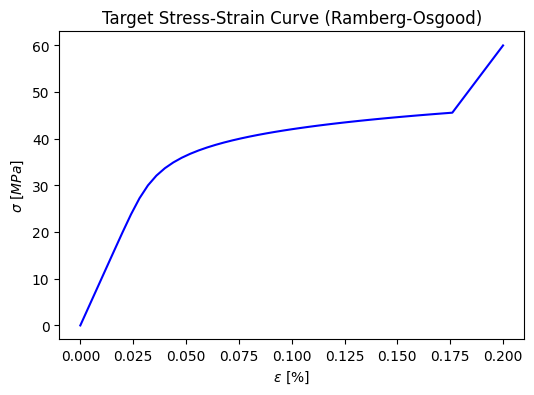

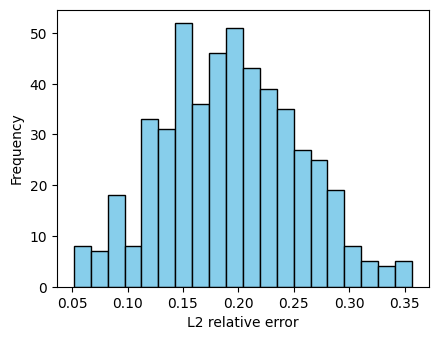

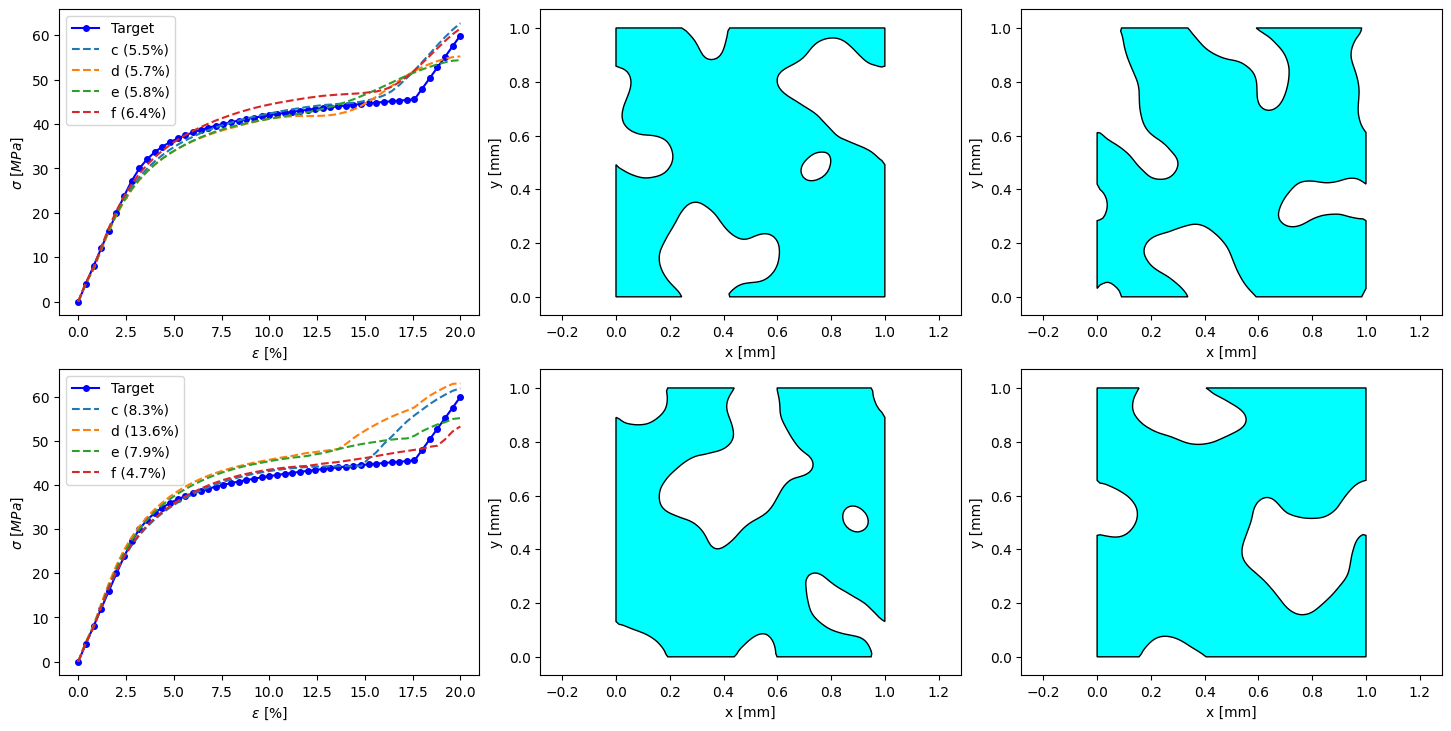

In [8]:
# Ondeand design case 2
# Material properties
E = 1000     # Young's modulus (MPa)
sigma_0 = 30  # Reference yield stress (Pa)
alpha = 0.002   # Coefficient
n = 10           # Hardening exponent
y_demand1 = ondemand_target(E, sigma_0, alpha, n, idx_e=45)
y_demand_target1 = (y_demand1-s_shift)/s_scale
y_demand_target1 = torch.tensor(y_demand_target1)[None, :].to(device)
filebase = f"./abaqus_sims/ondemand_case2"
seed = 43
np.random.seed(seed)
seed_ = np.random.randint(0, 100000)
geo_contours, Ypred, Ytarg = design_test(
    y_demand_target1, filebase, num_sol=500, threshold=None, w=2, seed=seed_, overwrite=True)
